In [104]:
import os
import sys
import typing as t
from PIL import Image

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import skimage.color

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data

In [105]:
SOURCE_DIR_V1 = R"F:\master-thesis-databases\research_database\StyleGanv1"
SOURCE_DIR_V2 = R"F:\master-thesis-databases\research_database\StyleGanv2"
SOURCE_DIR_FFHQ = R"F:\master-thesis-databases\research_database\FFHQ"

In [106]:
dataset_gen = get_image_data(SOURCE_DIR_V1, type='float', grayscale=False)

In [108]:
def all_colorspaces_from_rgb(np_rgb_img):
    """R,G,B,H,S,V,Y,Cb,Cr"""
    if np_rgb_img.shape[2] < 3 or len(np_rgb_img.shape) != 3:
        raise ValueError("Bad shape of input image")
    np_img_hsv = skimage.color.rgb2hsv(img)
    np_img_ycbcr = skimage.color.rgb2ycbcr(img) / 255
    # (x,y,9) shape insted of (x,y,3)
    new_shape = list(np_rgb_img.shape[:2])+[9]
    np_img_all_colors = np.empty(new_shape)
    np_img_all_colors[:,:,:3] = np_rgb_img
    np_img_all_colors[:,:,3:6] = np_img_hsv
    np_img_all_colors[:,:,6:] = np_img_ycbcr
    return np_img_all_colors

In [109]:
bins=256
hist_range = (0,1)
number_of_images = 0
number_of_colorspaces = 9
np_avg_hist = np.zeros((bins,number_of_colorspaces), dtype=np.float64)
for img in dataset_gen:
        np_all_colorspaces = all_colorspaces_from_rgb(img)
        for colorspace in range(number_of_colorspaces):
            hist, _ = np.histogram(np_all_colorspaces[:,:,colorspace],                                               density=True, bins=bins, range=hist_range)
            np_avg_hist[:,colorspace] += hist
        number_of_images += 1
        if np_avg_hist.max() > 0.95*np.finfo(np_avg_hist.dtype).max:
            raise ValueError("Dataset to large")
            break
        # elif number_of_images == max_number_of_images:
        #     print("Finish calcluating avg histogram")
        #     break
np_avg_hist, bins = np_avg_hist / number_of_images, range(0, bins)

len: 1000


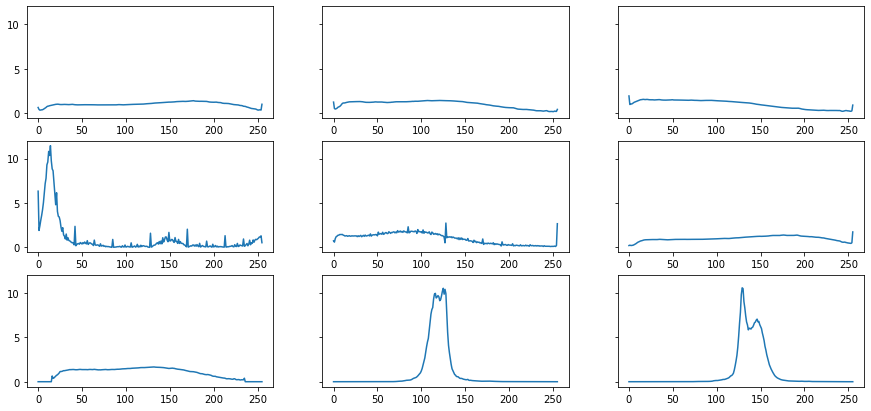

In [110]:
fig, axs = plt.subplots(ncols=3, nrows=3,  sharey=True, figsize=(15,7))
for i in range(9):
    axs[int(i/3),i%3].plot(list(bins), np_avg_hist[:,i])

